In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from pyparsing import python_style_comment
from itertools import islice
import scipy.sparse as sps
from scipy.sparse import diags
from functools import lru_cache
import pandas as pd

In [2]:
comb_cache = {}
comb_n_cache = {}
comb_n_M_minus_n_cache = {}

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N

def combination(n, r):
    if (n, r) in comb_cache:
        return comb_cache[(n, r)]
    else:
        comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
        comb_cache[(n, r)] = comb
        return comb
    
@lru_cache(maxsize=None)
def compute_N(n):
  def agen(): # generator of terms
      aset, sset, k = set(), set(), 0
      while True:
          k += 1
          while any(k+an in sset for an in aset): k += 1
          yield k; sset.update(k+an for an in aset); aset.add(k)
  a = list(islice(agen(), 100))
  photon = list(map(lambda v: v-1, a))
  compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  return compute_N[n]

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute(n, P_l, l):
    if (n, l) in comb_n_cache:
        comb_n = comb_n_cache[(n, l)]
    else:
        comb_n = combination(n, l)
        comb_n_cache[(n, l)] = comb_n

    return comb_n * (P_l)**l * (1 - P_l)**(n - l)

def Add_Distribute(n, P_a, a):
    N_n = compute_N(n)
    M_minus_n = compute_N(n) - N_n
    if (N_n, M_minus_n, a) in comb_n_M_minus_n_cache:
        comb_Nn_Mn = comb_n_M_minus_n_cache[(N_n, M_minus_n, a)]
    else:
        comb_Nn_Mn = combination(N_n + M_minus_n, a)
        comb_n_M_minus_n_cache[(N_n, M_minus_n, a)] = comb_Nn_Mn

    return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

# define a separate function for computing the probability of error
def P_err(n, P_l, P_a,l,a):
  return Loss_Distribute(n,P_l,l) * Add_Distribute(n,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# We put these into P_D for re-normalization, These are the probability of error we can correct
# define separate functions for computing the probability of success
def P_Success0(n,P_l,P_a,l,a):
  return P_err(n,P_l, P_a,0,0)

def P_Success1(n,P_l,P_a,l,a):
  P0 = P_Success0(n, P_l, P_a,l,a)
  P1 = P_err(n, P_l, P_a, l=0, a=1) + P_err(n, P_l, P_a, l=1, a=0)
  return P0 + P1

def P_Success2(n,P_l,P_a,l,a):
  P1 = P_Success1(n, P_l, P_a)
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  return P1 + P2

def P_Success3(n,P_l,P_a,l,a):
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  P3 = P_err(n, P_l, P_a,1,2) + P_err(n, P_l, P_a, 2,1) + P_err(n, P_l, P_a,3,0) + P_err(n, P_l, P_a,0,3)
  return P2 + P3

def P_D(n,P_l,P_a,l,a):
# we only consider at most 1 error, i.e. P_0 + P_1
  return 1 - P_Success1(n,P_l,P_a,l,a)

In [3]:
def P_AB_BPPM_diagonal(n, P_D):
    factorial_n = math.factorial(n)
    diag_data = (1/factorial_n) * (1-P_D) 
    # matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
    return diag_data

def P_A_BPPM_diagonal(P_AB_BPPM_diagonal, P_D):
    if P_D == 1:
        return [1 for row in P_AB_BPPM_diagonal]
    else:
        return [1/(1-P_D) * sum(row) for row in P_AB_BPPM_diagonal] 
# sum over the elements in columns in the probability matrix P_AB
# renormalized in P_AB already

def P_B_BPPM_diagonal(P_AB_BPPM_diagonal, P_D):
    if P_D == 1:
        return [1 for col in zip(*P_AB_BPPM_diagonal)]
    else:
        return [1/(1-P_D) * sum(col) for col in zip(*P_AB_BPPM_diagonal)]

def H_AB_BPPM_diagonal(n,P_AB_BPPM_diagonal, P_D):
    factorial_n = math.factorial(n)
    P_AB_BPPM_diagonal = np.where(P_AB_BPPM_diagonal == 0, 1e-9, P_AB_BPPM_diagonal)  # replace zero values with 1e-9
    H = - factorial_n * (P_AB_BPPM_diagonal * np.log2(np.where(P_AB_BPPM_diagonal == 0, 1, P_AB_BPPM_diagonal))).sum()
    return H
    
def I_AB_BPPM_diagonal(n, P_AB_BPPM_diagonal, P_D):
    factorial_n = math.factorial(n)
    H_AB_BPPM_diag = H_AB_BPPM_diagonal(n, P_AB_BPPM_diagonal, P_D)
    I_AB = H_AB_BPPM_diag *(1-P_D) 
    return I_AB

In [ ]:
def compute_M_OOK(n_OOK):
  M_OOK = n_OOK * 2
  return M_OOK

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_OOK(n_OOK, M_OOK):
    return math.factorial((int(M_OOK))) / (math.factorial((int(M_OOK - n_OOK))) * math.factorial((int(n_OOK))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_OOK(n_OOK, P_l, l):
    return combination(n_OOK, l) * (P_l)**l * (1 - P_l)**(n_OOK - l)

def Add_Distribute_OOK(n_OOK, M_OOK, P_a, a):
    return combination(M_OOK - n_OOK, a) * (P_a)**a * (1 - P_a)**(M_OOK - n_OOK - a)

# define a separate function for computing the probability of error
def P_err_OOK(n_OOK, M_OOK, P_l, P_a,l,a):
  return Loss_Distribute_OOK(n_OOK,P_l,l) * Add_Distribute_OOK(n_OOK, M_OOK, P_a, a)

def P_Success_OOK_0(n_OOK,M_OOK, P_l,P_a,l,a):
  return P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=0, a=0) 

def P_Success_OOK_1(n_OOK,M_OOK, P_l,P_a,l,a):
  P0 = P_Success_OOK_0(n_OOK,M_OOK, P_l,P_a,l,a)
  P1 = P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=0, a=1)  + P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=1, a=0) 
  return P0 + P1

def P_D_OOK(n_OOK,M_OOK, P_l,P_a, l=0,a=0):
  return 1 - P_Success_OOK_1(n_OOK,M_OOK, P_l,P_a, l, a)

def P_AB_OOK_diagonal(n_OOK, P_D_OOK) :
    diag_data = 1/n_OOK * (1-P_D_OOK)  #  1/ (2**n_OOK) (2**n_OOK) # probability
    return diag_data

# sum over the elements in rows in the probability matrix P_AB
def P_A_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
    if P_D_OOK == 1:
        return [1 for row in P_AB_OOK_diagonal]
    else:
        return [1 / (1-P_D_OOK) * sum(row) for row in P_AB_OOK_diagonal] # 1/(1-P_D_PPM)*
    
# sum over the elements in columns in the probability matrix P_AB
def P_B_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
    if P_D_OOK == 1:
        return [1 for col in zip(*P_AB_OOK_diagonal)]
    else:
        return [1 / (1-P_D_OOK) * sum(col) for col in zip(*P_AB_OOK_diagonal)]

# def H_A_OOK(P_AB_OOK):
#      P_A_OOK = np.sum(P_AB_OOK, axis=1)
#      H_a_OOK = np.sum(-P_A_OOK * np.log2(np.where(P_A_OOK == 0, 1, P_A_OOK)))
#      return H_a_OOK

# def H_B_OOK(P_AB_OOK):
#      P_B_OOK = np.sum(P_AB_OOK, axis=0)
#      H_b_OOK = np.sum(-P_B_OOK * np.log2(np.where(P_B_OOK == 0, 1, P_B_OOK)))
#      return H_b_OOK

def H_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK):
    P_AB_OOK_diagonal = np.where(P_AB_OOK_diagonal == 0, 1e-9, P_AB_OOK_diagonal)  # replace zero values with 1e-9
    H_OOK = - (P_AB_OOK_diagonal * np.log2(P_AB_OOK_diagonal)).sum() # 2**n_OOK *
    return H_OOK

# def I_AB_OOK(H_A_OOK, H_B_OOK, H_AB_OOK, P_D_OOK):
#     if np.isnan(H_AB_OOK):
#         return 0
#     else:
#         return ((H_A_OOK + H_B_OOK - H_AB_OOK)) * (1-P_D_OOK)

def I_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK, P_D_OOK):
    H_AB_OOK_diag = H_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK)
    I_AB = H_AB_OOK_diag *(1-P_D_OOK) 
    return I_AB
    
    
def P_AB_OOK_diagonal(n_OOK):
    diag_data = 1/ (2**n_OOK) * (1-P_D_OOK)  #  (2**n_OOK) # probability
    return diag_data

# sum over the elements in rows in the probability matrix P_AB
def P_A_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
    if P_D_OOK == 1:
        return [1 for row in P_AB_OOK_diagonal]
    else:
        return [1 / (1-P_D_OOK) * sum(row) for row in P_AB_OOK_diagonal] # 1/(1-P_D_PPM)*
    
# sum over the elements in columns in the probability matrix P_AB
def P_B_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
    if P_D_OOK == 1:
        return [1 for col in zip(*P_AB_OOK_diagonal)]
    else:
        return [1 / (1-P_D_OOK) * sum(col) for col in zip(*P_AB_OOK_diagonal)]


In [20]:
def combination(n, r):
    if (n, r) in comb_cache:
        return comb_cache[(n, r)]
    else:
        comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
        comb_cache[(n, r)] = comb
        return comb

In [59]:
def compute_M_OOK(n_OOK):
  M_OOK = n_OOK * 2
  return M_OOK

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_OOK(n_OOK, M_OOK):
    if n_OOK > M_OOK:
        return 0  # Invalid input, return 0 or handle the error appropriately
    else:
        return math.factorial(M_OOK) / (math.factorial(M_OOK - n_OOK) * math.factorial(n_OOK))


# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_OOK(n_OOK, P_l, l):
    return combination(n_OOK, l) * (P_l)**l * (1 - P_l)**(n_OOK - l)

def Add_Distribute_OOK(n_OOK, M_OOK, P_a, a):
    return combination(M_OOK - n_OOK, a) * (P_a)**a * (1 - P_a)**(M_OOK - n_OOK - a)

# define a separate function for computing the probability of error
def P_err_OOK(n_OOK, M_OOK, P_l, P_a,l,a):
  return Loss_Distribute_OOK(n_OOK,P_l,l) * Add_Distribute_OOK(n_OOK, M_OOK, P_a, a)

def P_Success_OOK_0(n_OOK,M_OOK, P_l,P_a,l,a):
  return P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=0, a=0) 

def P_Success_OOK_1(n_OOK,M_OOK, P_l,P_a,l,a):
  P0 = P_Success_OOK_0(n_OOK,M_OOK, P_l,P_a,l,a)
  P1 = P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=0, a=1)  + P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=1, a=0) 
  return P0 + P1

def P_D_OOK(n_OOK,M_OOK, P_l,P_a, l=0,a=0):
  return 1 - P_Success_OOK_1(n_OOK,M_OOK, P_l,P_a, l, a)

def P_AB_OOK_diagonal(n_OOK, P_D_OOK) :
    diag_data = 1/2**n_OOK # / (2**n_OOK)   #  1/ (2**n_OOK) # probability
    return diag_data

# sum over the elements in rows in the probability matrix P_AB
def P_A_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
    if P_D_OOK == 1:
        return [1 for row in P_AB_OOK_diagonal]
    else:
        return [ sum(row) for row in P_AB_OOK_diagonal] 
    
# sum over the elements in columns in the probability matrix P_AB
def P_B_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
    if P_D_OOK == 1:
        return [1 for col in zip(*P_AB_OOK_diagonal)]
    else:
        return [sum(col) for col in zip(*P_AB_OOK_diagonal)]

def H_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK):
    P_AB_OOK_diagonal = np.where(P_AB_OOK_diagonal == 0, 1e-9, P_AB_OOK_diagonal)  # replace zero values with 1e-9
    H_OOK = - 2**n_OOK * (P_AB_OOK_diagonal * np.log2(P_AB_OOK_diagonal)).sum() # 2**n_OOK *
    return H_OOK

def I_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK, P_D_OOK):
    H_AB_OOK_diag = H_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK)
    I_AB =   H_AB_OOK_diag *(1-P_D_OOK) 
    return I_AB

In [60]:
I_AB_OOK_list_0 = []
I_AB_OOK_list_0_1 = []

IperPhoton_AB_OOK_list_0 = []
IperTimeBin_AB_OOK_list_0 = []
IperPhotonTimeBin_AB_OOK_list_0 = []

IperPhoton_AB_OOK_list_0_1 = []
IperTimeBin_AB_OOK_list_0_1 = []
IperPhotonTimeBin_AB_OOK_list_0_1 = []

TimeBin_OOK_list_0 = []
TimeBin_OOK_list_0_1 = []

for n_OOK in range(3,39):
    P = 0
    M_OOK = compute_M_OOK(n_OOK)
    TimeBin_OOK_list_0.append(M_OOK)
    P_D_OOK_val = P_D_OOK(n_OOK, M_OOK, P, 0, 0, 0)
    P_AB_OOK_val = P_AB_OOK_diagonal(n_OOK, P_D_OOK_val)
    H_AB_OOK_val = H_AB_OOK_diagonal(P_AB_OOK_val, n_OOK)
    I_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)
    I_AB_OOK_list_0.append(I_AB_OOK_val)

    IperPhoton_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / n_OOK
    IperPhoton_AB_OOK_list_0.append(IperPhoton_AB_OOK_val)

    IperTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / M_OOK
    IperTimeBin_AB_OOK_list_0.append(IperTimeBin_AB_OOK_val)

    IperPhotonTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)/ (n_OOK * M_OOK)
    IperPhotonTimeBin_AB_OOK_list_0.append(IperPhotonTimeBin_AB_OOK_val)

for n_OOK in range(3,39):
    P = 0.1
    M_OOK = compute_M_OOK(n_OOK)
    TimeBin_OOK_list_0_1.append(M_OOK)
    P_D_OOK_val = P_D_OOK(n_OOK, M_OOK, P, 0, 0, 0)
    P_AB_OOK_val = P_AB_OOK_diagonal(n_OOK, P_D_OOK_val)
    H_AB_OOK_val = H_AB_OOK_diagonal(P_AB_OOK_val, n_OOK)
    I_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)
    I_AB_OOK_list_0_1.append(I_AB_OOK_val)

    IperPhoton_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / n_OOK
    IperPhoton_AB_OOK_list_0_1.append(IperPhoton_AB_OOK_val)

    IperTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / M_OOK
    IperTimeBin_AB_OOK_list_0_1.append(IperTimeBin_AB_OOK_val)

    IperPhotonTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)/ (n_OOK * M_OOK)
    IperPhotonTimeBin_AB_OOK_list_0_1.append(IperPhotonTimeBin_AB_OOK_val)

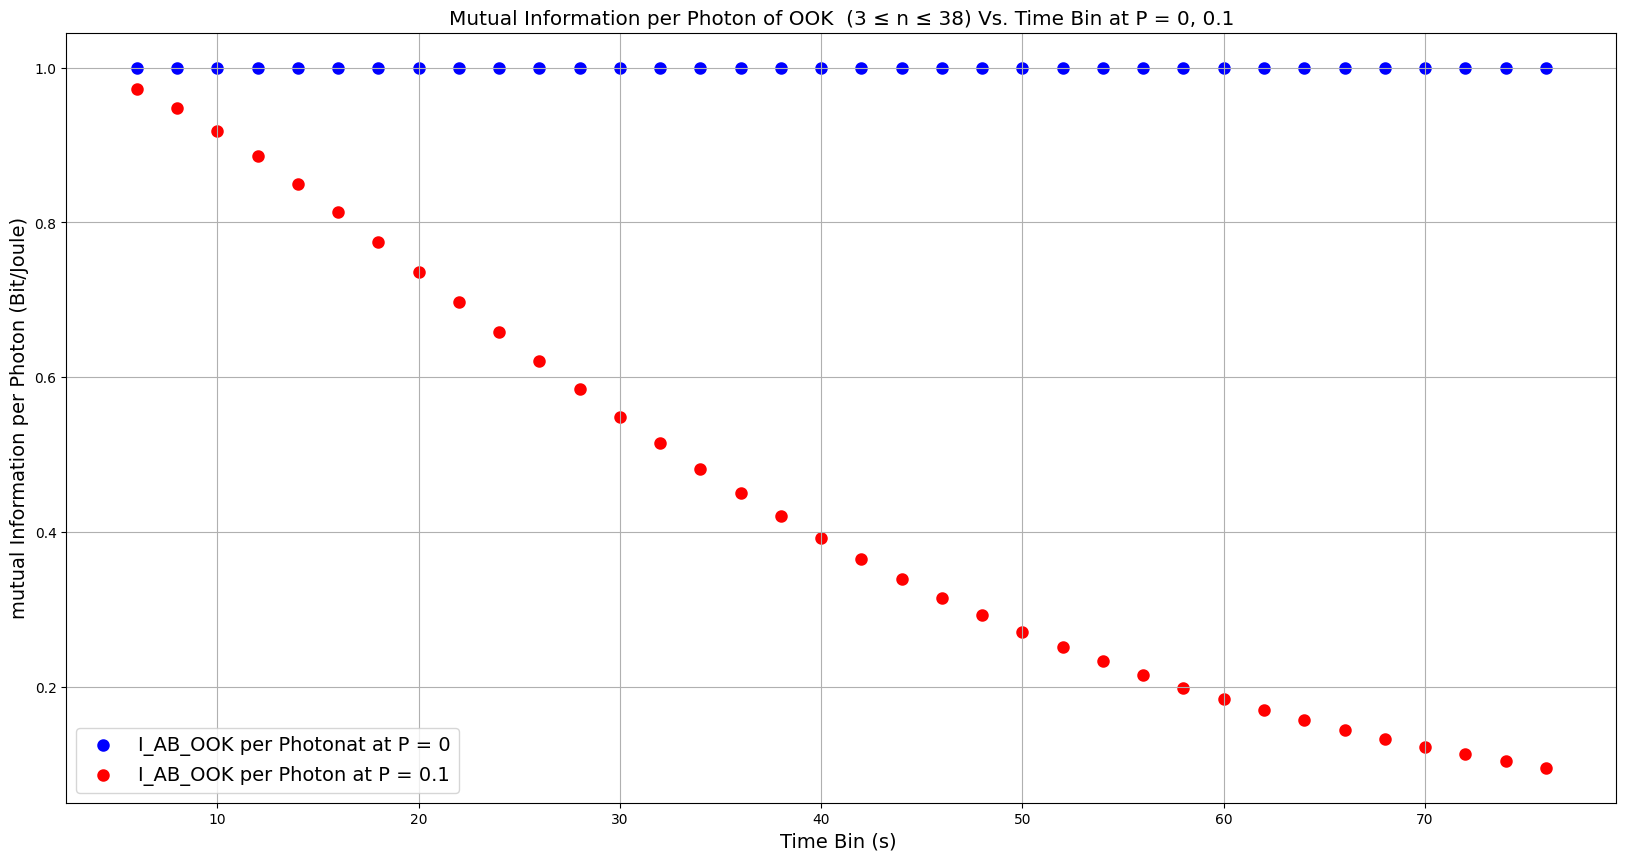

In [61]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photonat at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
plt.title('Mutual Information per Photon of OOK  (3 \u2264 n \u2264 38) Vs. Time Bin at P = 0, 0.1', fontsize='x-large')
plt.xlabel('Time Bin (s) ', fontsize = 14)
plt.ylabel('mutual Information per Photon (Bit/Joule)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)